<a href="https://colab.research.google.com/github/EmiLaPiola/NumLabIMC/blob/main/Tp_imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import os, requests
from PIL import Image
from io import BytesIO
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

Primero hacemos nuestras imagenes reales

In [64]:
import os, requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# === Carpetas ===
base_dir = "/content/fake_faces"
reales_dir = os.path.join(base_dir, "reales")
os.makedirs(reales_dir, exist_ok=True)

# === Generar 100 URLs reales (mezcla hombres/mujeres) ===
real_urls = []
for i in range(50):
    real_urls.append(f"https://randomuser.me/api/portraits/men/{i}.jpg")
    real_urls.append(f"https://randomuser.me/api/portraits/women/{i}.jpg")

# === Descarga ===
for i, url in enumerate(tqdm(real_urls, desc="Descargando imágenes reales")):
    try:
        r = requests.get(url, timeout=15)
        img = Image.open(BytesIO(r.content)).convert("RGB")
        img = img.resize((256, 256))
        img.save(os.path.join(reales_dir, f"real_{i+1}.jpg"))
    except Exception as e:
        print(f"❌ Error en imagen {i+1}: {e}")

print("\n✅ Carpeta de reales lista:", reales_dir)
print("Total reales:", len(os.listdir(reales_dir)))


Descargando imágenes reales: 100%|██████████| 100/100 [00:06<00:00, 15.13it/s]


✅ Carpeta de reales lista: /content/fake_faces/reales
Total reales: 100


Imagenes sinteticas :

In [65]:
import os, requests
from PIL import Image
from io import BytesIO

# === Carpetas ===
base_dir = "/content/fake_faces"
sinteticas_dir = os.path.join(base_dir, "sinteticas")
os.makedirs(sinteticas_dir, exist_ok=True)

# === TUS 5 IMÁGENES SINTÉTICAS ===
fake_urls = [
    "https://neuroflash.com/wp-content/uploads/2022/11/KI-generierte-Gesichter-3.png",
    "https://neuroflash.com/wp-content/uploads/2022/11/KI-generierte-Gesichter-7.png",
    "https://www.muyinteresante.com/wp-content/uploads/sites/5/2025/04/rostro-jesus-de-nazaret-chatgpt.jpg?resize=1024,683",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQeManGGeR3G3iznKV55CnG7DWA_3_kzGOoVtr_aLIV2UQ21lmvD6YG4UZjbInoJS-P7Lc&usqp=CAU",
    "https://bcw-media.s3.ap-northeast-1.amazonaws.com/yce_avatar_topbanner_mb_1_927935f20c.jpg"
]

# === Descarga de imágenes sintéticas ===
for i, url in enumerate(fake_urls):
    try:
        r = requests.get(url, timeout=15)
        img = Image.open(BytesIO(r.content)).convert("RGB")
        img = img.resize((256, 256))
        img.save(os.path.join(sinteticas_dir, f"fake_{i+1}.jpg"))
        print(f"✅ Fake {i+1} guardada")
    except Exception as e:
        print(f"❌ Error en {url} → {e}")

print("\n✅ Carpeta de sintéticas lista:", sinteticas_dir)
print("Total sintéticas:", len(os.listdir(sinteticas_dir)))


✅ Fake 1 guardada
✅ Fake 2 guardada
✅ Fake 3 guardada
✅ Fake 4 guardada
✅ Fake 5 guardada

✅ Carpeta de sintéticas lista: /content/fake_faces/sinteticas
Total sintéticas: 5


VEAMOSLAS

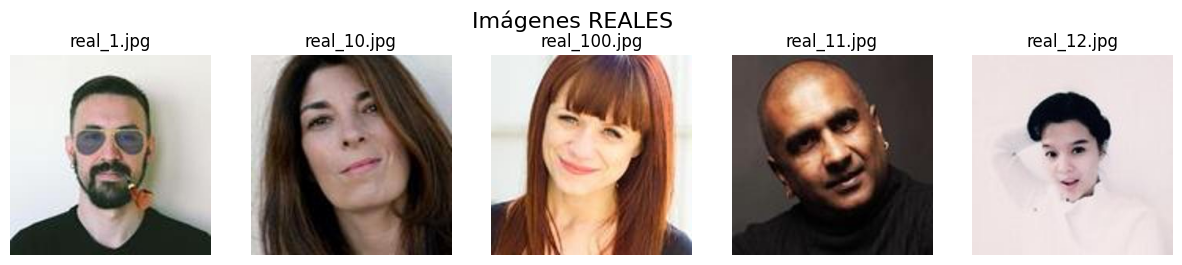

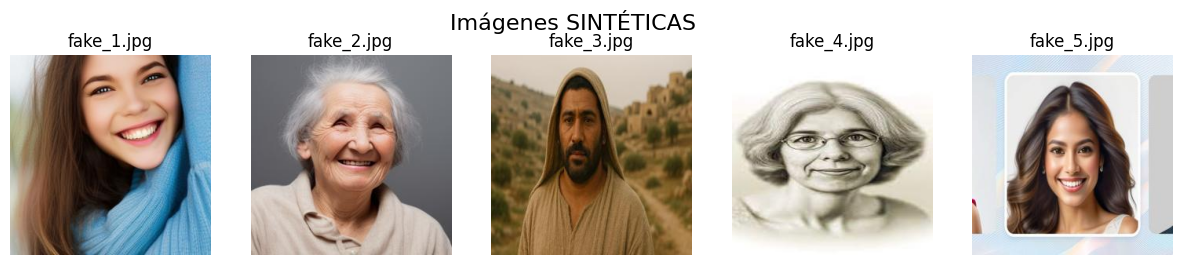

In [66]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# --- Carpetas ---
base_dir = "/content/fake_faces"
reales_dir = os.path.join(base_dir, "reales")
sinteticas_dir = os.path.join(base_dir, "sinteticas")

# --- Función para mostrar una cuadrícula de imágenes ---
def mostrar_imagenes(carpeta, titulo, n=5):
    files = sorted(os.listdir(carpeta))[:n]
    plt.figure(figsize=(15, 3))
    for i, f in enumerate(files):
        img = Image.open(os.path.join(carpeta, f))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f)
    plt.suptitle(titulo, fontsize=16)
    plt.show()

# --- Mostrar ---
mostrar_imagenes(reales_dir, "Imágenes REALES")
mostrar_imagenes(sinteticas_dir, "Imágenes SINTÉTICAS")


modelo :

In [67]:

# MODELO

class FakeFaceClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 1)
        )

    def forward(self, x):
        return self.backbone(x).squeeze(1)


# ENTRENAMIENTO

def compute_metrics(y_true, y_pred):
    y_pred_bin = (y_pred >= 0.5).astype(int)
    return accuracy_score(y_true, y_pred_bin)

def train_model(model, train_dl, val_dl, device, epochs=5):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        preds_all, labels_all = [], []
        for imgs, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} [train]"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds_all += torch.sigmoid(outputs).detach().cpu().numpy().tolist()
            labels_all += labels.cpu().numpy().tolist()
        acc_train = compute_metrics(np.array(labels_all), np.array(preds_all))

        # Validación
        model.eval()
        preds_all, labels_all = [], []
        with torch.no_grad():
            for imgs, labels in val_dl:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds_all += torch.sigmoid(outputs).cpu().numpy().tolist()
                labels_all += labels.cpu().numpy().tolist()
        acc_val = compute_metrics(np.array(labels_all), np.array(preds_all))
        print(f"Epoch {epoch+1}: Train={acc_train:.2f} | Val={acc_val:.2f}")
        if acc_val > best_acc:
            best_acc = acc_val
            torch.save(model.state_dict(), "best_fakeface_model.pth")

    print(f"\n✅ Entrenamiento finalizado (mejor accuracy={best_acc:.2f})")

def main():
    dataset_root = "/content/fake_faces"
    full_dataset = FaceDataset(dataset_root, transform=train_tf)
    n = len(full_dataset)
    n_train = int(0.8 * n)
    n_val = n - n_train
    train_ds, val_ds = torch.utils.data.random_split(full_dataset, [n_train, n_val])
    val_ds.dataset.transform = val_tf

    train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=4, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FakeFaceClassifier().to(device)

    train_model(model, train_dl, val_dl, device, epochs=10)

if __name__ == "__main__":
    main()

Epoch 1/10 [train]: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


Epoch 1: Train=0.43 | Val=0.90


Epoch 2/10 [train]: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


Epoch 2: Train=0.90 | Val=0.95


Epoch 3/10 [train]: 100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


Epoch 3: Train=0.98 | Val=0.90


Epoch 4/10 [train]: 100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


Epoch 4: Train=1.00 | Val=0.90


Epoch 5/10 [train]: 100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


Epoch 5: Train=1.00 | Val=0.90


Epoch 6/10 [train]: 100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


Epoch 6: Train=1.00 | Val=0.90


Epoch 7/10 [train]: 100%|██████████| 21/21 [00:30<00:00,  1.45s/it]


Epoch 7: Train=1.00 | Val=0.90


Epoch 8/10 [train]: 100%|██████████| 21/21 [00:30<00:00,  1.44s/it]


Epoch 8: Train=1.00 | Val=0.90


Epoch 9/10 [train]: 100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


Epoch 9: Train=1.00 | Val=0.90


Epoch 10/10 [train]: 100%|██████████| 21/21 [00:29<00:00,  1.42s/it]


Epoch 10: Train=1.00 | Val=0.95

✅ Entrenamiento finalizado (mejor accuracy=0.95)


Que clasifico como que ?

/tmp/ipython-input-3623885782.py:46: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


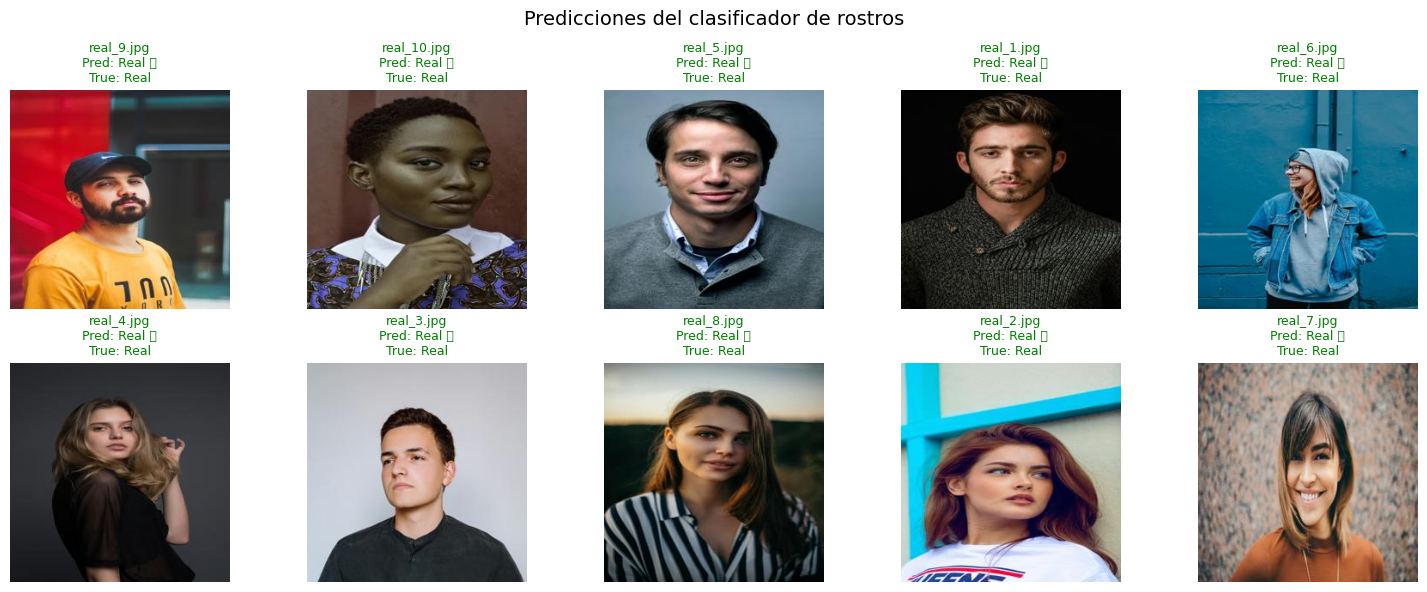

In [55]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import os

# === Cargar modelo entrenado ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FakeFaceClassifier().to(device)
model.load_state_dict(torch.load("best_fakeface_model.pth", map_location=device))
model.eval()

# === Dataset de prueba ===
test_dataset = FaceDataset("/content/fake_faces", transform=val_tf)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# === Predicción ===
predicciones = []
for imgs, labels in test_loader:
    imgs = imgs.to(device)
    outputs = model(imgs)
    probs = torch.sigmoid(outputs).cpu().item()
    pred = int(probs >= 0.5)
    predicciones.append((probs, pred, int(labels.item())))

# === Mostrar imágenes y resultados ===
files = test_dataset.files
plt.figure(figsize=(15, 6))
for i, (prob, pred, true) in enumerate(predicciones):
    img = Image.open(files[i])
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

    # Etiqueta de verdad
    true_label = "Real" if true == 1 else "Sintética"
    pred_label = "Real ✅" if pred == 1 else "Sintética ❌"
    color = "green" if pred == true else "red"

    plt.title(f"{os.path.basename(files[i])}\nPred: {pred_label}\nTrue: {true_label}",
              fontsize=9, color=color)

plt.suptitle("Predicciones del clasificador de rostros", fontsize=14)
plt.tight_layout()
plt.show()


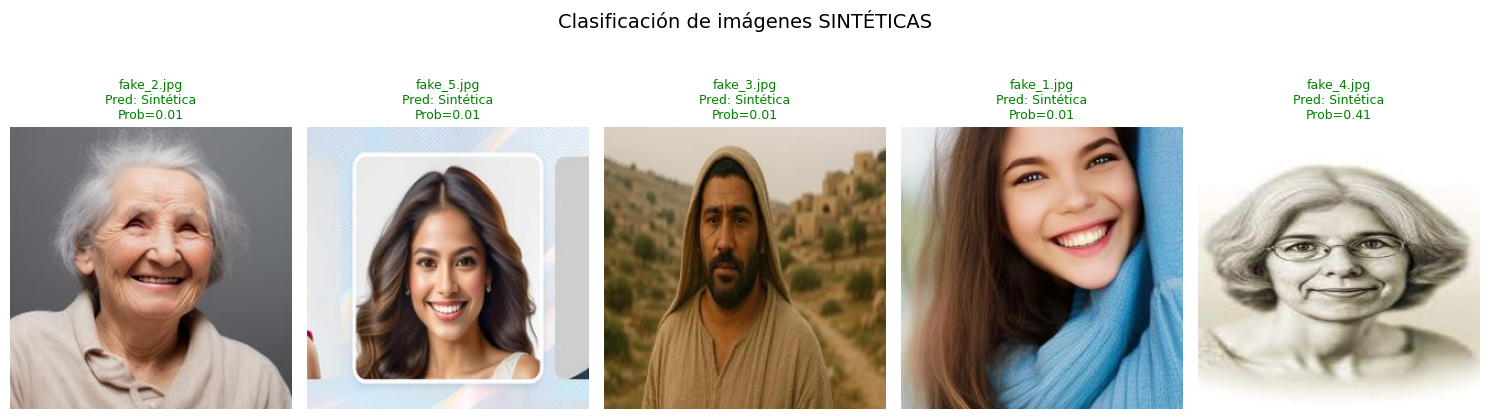

In [56]:
import matplotlib.pyplot as plt
from PIL import Image

# Filtrar las que eran sintéticas (true == 0)
synthetic_results = [(files[i], prob, pred, true)
                     for i, (prob, pred, true) in enumerate(predicciones)
                     if true == 0]

plt.figure(figsize=(15, 5))
for i, (file, prob, pred, true) in enumerate(synthetic_results[:5]):  # mostrar 5
    img = Image.open(file)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

    pred_label = "Real" if pred == 1 else "Sintética"
    color = "green" if pred == true else "red"
    plt.title(f"{os.path.basename(file)}\nPred: {pred_label}\nProb={prob:.2f}",
              fontsize=9, color=color)

plt.suptitle("Clasificación de imágenes SINTÉTICAS", fontsize=14)
plt.tight_layout()
plt.show()


prediccion sobre datos nuevos ?

Predicción: Sintética ❌ | Probabilidad de ser real: 0.33


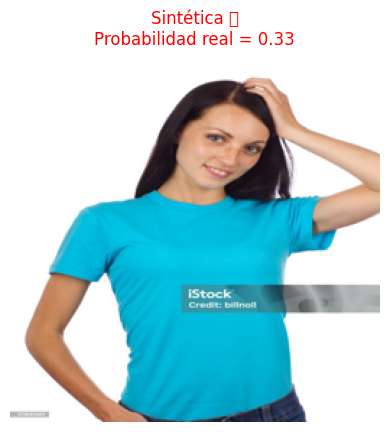

In [79]:
from PIL import Image
import requests
from io import BytesIO
import torch

# === URL de la nueva imagen ===

url = "https://media.istockphoto.com/id/173937507/es/foto/mujer-joven-con-camisa-azul-claro.jpg?s=1024x1024&w=is&k=20&c=5l7UGyZXT1RMBW6JgdEjgG8jB845NombylY5Z22hXoM="

# === Descargar y preparar ===
r = requests.get(url, timeout=15)
img = Image.open(BytesIO(r.content)).convert("RGB")
img_resized = img.resize((256, 256))

# === Transformación (igual que val_tf) ===
img_tensor = val_tf(img_resized).unsqueeze(0).to(device)

# === Cargar modelo entrenado ===
model = FakeFaceClassifier().to(device)
model.load_state_dict(torch.load("best_fakeface_model.pth", map_location=device))
model.eval()

# === Predicción ===
with torch.no_grad():
    output = model(img_tensor)
    prob = torch.sigmoid(output).cpu().item()
    pred = "Real ✅" if prob >= 0.5 else "Sintética ❌"

print(f"Predicción: {pred} | Probabilidad de ser real: {prob:.2f}")

# === Mostrar la imagen ===
import matplotlib.pyplot as plt
plt.imshow(img_resized)
plt.axis("off")
plt.title(f"{pred}\nProbabilidad real = {prob:.2f}", color="green" if prob >= 0.5 else "red")
plt.show()
